# Chapter 3.2 - Chapter 3.7

In this notebook, we demonstrate how to construct various neural networks, ranging from the canonical fully connected neural networks to transformers. Note that the focus here is on network architecture, so we will not adjust hyperparameters. We will use a fixed validation set with early stop to control for overfitting problem. In Chapter 4, we demonstrate how to perform cross-valiation to select the most appropriate hyperparameters. 

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt 
from Utilis.early_stopper import EarlyStopping

torch.manual_seed(42)
np.random.seed(42)

In [17]:
def train_model(model, X_train, y_train, X_val, y_val, X_test,
                epochs=5, lr=1e-3, batch_size=32, patience=5):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    dataset = torch.utils.data.TensorDataset(X_train, y_train)
    dataloader = torch.utils.data.DataLoader(dataset,
                                             batch_size=batch_size,
                                             shuffle=True)
    
    early_stopper = EarlyStopping(patience, min_delta=1e-4, verbose=True)

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0

        for batch_X, batch_y in dataloader:
            optimizer.zero_grad()
            out = model(batch_X)
            loss = criterion(out, batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item() * batch_X.size(0)

        epoch_loss /= len(dataloader.dataset)
        model.eval()
        with torch.no_grad():
            y_pred_val = model(X_val)
            val_loss = criterion(y_pred_val, y_val).item()

        print(f"Epoch {epoch+1}/{epochs}, "
              f"Train loss: {epoch_loss:.4f}, "
              f"Validation loss: {val_loss:.4f}")
        
        early_stopper(val_loss)
        if early_stopper.early_stop:
            print("Early stopping triggered!")
            break
        
    y_pred_test = model(X_test)    
    return model, y_pred_test

In [18]:
class MLP(nn.Module):
    def __init__(self, seq_length, n_features):
        super(MLP, self).__init__()
        self.flat_dim = seq_length * n_features
        self.net = nn.Sequential(
            nn.Flatten(),                   # (batch, seq_length*n_features)
            nn.Linear(self.flat_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)                
        )
    def forward(self, x):
        return self.net(x)

class CNN(nn.Module):
    def __init__(self, n_features, out_channels=32):
        super(CNN, self).__init__()
        # in_channels = n_features, kernel_size=3, padding=1 
        self.conv = nn.Sequential(
            nn.Conv1d(in_channels=n_features,
                      out_channels=out_channels,
                      kernel_size=3,
                      padding=1),
            nn.ReLU(),
            nn.Conv1d(out_channels, out_channels,
                      kernel_size=3,
                      padding=1),
            nn.ReLU()
        )
        self.pool = nn.AdaptiveAvgPool1d(1)  
        self.fc   = nn.Linear(out_channels, 1)

    def forward(self, x):
        # x: (batch, seq_length, n_features)
        x = x.permute(0, 2, 1)  
        x = self.conv(x)
        x = self.pool(x)        # shape: (batch, out_channels, 1)
        x = x.squeeze(-1)       # (batch, out_channels)
        x = self.fc(x)          # (batch,1)
        return x

class WaveNetLike(nn.Module):
    def __init__(self, n_features, out_channels=32,
                 kernel_size=2, dilation_depth=4):
        super(WaveNetLike, self).__init__()
        layers = []
        in_channels = n_features
        for d in range(dilation_depth):
            dilation_rate = 2 ** d
            padding = (kernel_size - 1) * dilation_rate
            conv = nn.Conv1d(
                in_channels=in_channels,
                out_channels=out_channels,
                kernel_size=kernel_size,
                dilation=dilation_rate,
                padding=padding
            )
            layers.append(conv)
            in_channels = out_channels

        self.convs = nn.ModuleList(layers)
        self.activation = nn.ReLU()
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc   = nn.Linear(out_channels, 1)

    def forward(self, x):
        # x: (batch, seq_length, n_features)
        x = x.permute(0, 2, 1)  # (batch, n_features, seq_length)

        for conv in self.convs:
            x = conv(x)
            x = self.activation(x)

        x = self.pool(x)        # (batch, out_channels, 1)
        x = x.squeeze(-1)       # (batch, out_channels)
        x = self.fc(x)          # (batch,1)
        return x

class LSTMModel(nn.Module):
    def __init__(self, n_features, hidden_size=64):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=n_features,
                            hidden_size=hidden_size,
                            batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )
    def forward(self, x):
        # x: (batch, seq_length, n_features)
        output, (h_n, c_n) = self.lstm(x)
        # output: (batch, seq_length, hidden_size)
        last_output = output[:, -1, :]  # (batch, hidden_size)
        return self.fc(last_output)

class TransformerModel(nn.Module):
    def __init__(self, seq_length, n_features, d_model=64, nhead=4, num_layers=2):
        super(TransformerModel, self).__init__()
        self.d_model = d_model

        self.input_fc = nn.Linear(n_features, d_model)
        self.pos_embedding = nn.Parameter(
            torch.randn(1, seq_length, d_model)
        )

        # TransformerEncoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=128,
            batch_first=True
        )
        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers=num_layers
        )
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(d_model, 1)

    def forward(self, x):
        # x: (batch, seq_length, n_features)
        x = self.input_fc(x)  # (batch, seq_length, d_model)

        seq_len = x.size(1)
        x = x + self.pos_embedding[:, :seq_len, :]
        x = self.transformer_encoder(x)  # (batch, seq_length, d_model)

        # Global Average Pooling over seq_length
        x = x.permute(0, 2, 1)
        x = self.pool(x)  # (batch, d_model, 1)
        x = x.squeeze(-1) # (batch, d_model)

        x = self.fc(x)    # (batch, 1)
        return x

I here simiulate some data to perform a regression problem. The x inputs have dimension of (batch_samples, time look-back windows, feature numbers).

In [19]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
N = 2000           
seq_length = 20    
n_features = 3    

# X: (N, seq_length, n_features)
X_np = np.random.randn(N, seq_length, n_features)
noise = 0.1 * np.random.randn(N)
y_np = 2 * X_np[:, -1, 0] + 3 * X_np[:, -1, 1] - 1.5 * X_np[:, -1, 2] + noise
y_np = y_np.reshape(-1, 1)  # shape (N,1)

split_index_val = int(N * 0.6)
split_index_test = int(N * 0.8)

X_train_np = X_np[:split_index_val]
y_train_np = y_np[:split_index_val]
X_val_np = X_np[split_index_val:split_index_test]
y_val_np = y_np[split_index_val:split_index_test]
X_test_np  = X_np[split_index_test:]
y_test_np  = y_np[split_index_test:]

X_train = torch.tensor(X_train_np, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train_np, dtype=torch.float32).to(device)
X_val = torch.tensor(X_val_np, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val_np, dtype=torch.float32).to(device)
X_test  = torch.tensor(X_test_np,  dtype=torch.float32).to(device)
y_test  = torch.tensor(y_test_np,  dtype=torch.float32).to(device)

print("Train X shape:", X_train.shape)
print("Train y shape:", y_train.shape)
print("Val X shape:", X_val.shape)
print("Val y shape:", y_val.shape)
print("Test  X shape:", X_test.shape)
print("Test  y shape:", y_test.shape)

Using device: cpu
Train X shape: torch.Size([1200, 20, 3])
Train y shape: torch.Size([1200, 1])
Val X shape: torch.Size([400, 20, 3])
Val y shape: torch.Size([400, 1])
Test  X shape: torch.Size([400, 20, 3])
Test  y shape: torch.Size([400, 1])


In [21]:
mlp_model = MLP(seq_length, n_features).to(device)
mlp_model, y_pred_mlp = train_model(mlp_model, X_train, y_train, X_val, y_val, X_test, epochs=20)

Epoch 1/20, Train loss: 14.4327, Validation loss: 13.6601
Epoch 2/20, Train loss: 11.9092, Validation loss: 9.5336
Validation loss improved. Resetting counter.
Epoch 3/20, Train loss: 5.5450, Validation loss: 2.4510
Validation loss improved. Resetting counter.
Epoch 4/20, Train loss: 1.0009, Validation loss: 0.6281
Validation loss improved. Resetting counter.
Epoch 5/20, Train loss: 0.3814, Validation loss: 0.4985
Validation loss improved. Resetting counter.
Epoch 6/20, Train loss: 0.2559, Validation loss: 0.4356
Validation loss improved. Resetting counter.
Epoch 7/20, Train loss: 0.1786, Validation loss: 0.4013
Validation loss improved. Resetting counter.
Epoch 8/20, Train loss: 0.1394, Validation loss: 0.3634
Validation loss improved. Resetting counter.
Epoch 9/20, Train loss: 0.1092, Validation loss: 0.3431
Validation loss improved. Resetting counter.
Epoch 10/20, Train loss: 0.0875, Validation loss: 0.3190
Validation loss improved. Resetting counter.
Epoch 11/20, Train loss: 0.0732

In [22]:
cnn_model = CNN(n_features=3).to(device)
cnn_model, y_pred_cnn = train_model(cnn_model, X_train, y_train, X_val, y_val, X_test, epochs=20)

Epoch 1/20, Train loss: 14.7283, Validation loss: 14.7697
Epoch 2/20, Train loss: 14.6585, Validation loss: 14.7004
Validation loss improved. Resetting counter.
Epoch 3/20, Train loss: 14.5831, Validation loss: 14.6444
Validation loss improved. Resetting counter.
Epoch 4/20, Train loss: 14.4707, Validation loss: 14.5164
Validation loss improved. Resetting counter.
Epoch 5/20, Train loss: 14.2877, Validation loss: 14.3151
Validation loss improved. Resetting counter.
Epoch 6/20, Train loss: 14.0879, Validation loss: 14.3229
No improvement in validation loss. Counter: 1/5
Epoch 7/20, Train loss: 13.8266, Validation loss: 14.0548
Validation loss improved. Resetting counter.
Epoch 8/20, Train loss: 13.7258, Validation loss: 13.7809
Validation loss improved. Resetting counter.
Epoch 9/20, Train loss: 13.3617, Validation loss: 13.5320
Validation loss improved. Resetting counter.
Epoch 10/20, Train loss: 13.0848, Validation loss: 13.2929
Validation loss improved. Resetting counter.
Epoch 11/20

In [23]:
wavenet_model = WaveNetLike(n_features=3).to(device)
wavenet_model, y_pred_wavenet = train_model(wavenet_model, X_train, y_train, X_val, y_val, X_test, epochs=20)

Epoch 1/20, Train loss: 14.8012, Validation loss: 14.7615
Epoch 2/20, Train loss: 14.7551, Validation loss: 14.7217
Validation loss improved. Resetting counter.
Epoch 3/20, Train loss: 14.5217, Validation loss: 14.5684
Validation loss improved. Resetting counter.
Epoch 4/20, Train loss: 13.9282, Validation loss: 13.4896
Validation loss improved. Resetting counter.
Epoch 5/20, Train loss: 12.5913, Validation loss: 12.2139
Validation loss improved. Resetting counter.
Epoch 6/20, Train loss: 10.5007, Validation loss: 9.4639
Validation loss improved. Resetting counter.
Epoch 7/20, Train loss: 7.5618, Validation loss: 5.9426
Validation loss improved. Resetting counter.
Epoch 8/20, Train loss: 4.3832, Validation loss: 3.4088
Validation loss improved. Resetting counter.
Epoch 9/20, Train loss: 2.5617, Validation loss: 2.1198
Validation loss improved. Resetting counter.
Epoch 10/20, Train loss: 1.5453, Validation loss: 1.3773
Validation loss improved. Resetting counter.
Epoch 11/20, Train loss

In [24]:
lstm_model = LSTMModel(n_features=3).to(device)
lstm_model, y_pred_lstm = train_model(lstm_model, X_train, y_train, X_val, y_val, X_test, epochs=20)

Epoch 1/20, Train loss: 14.2761, Validation loss: 13.4701
Epoch 2/20, Train loss: 10.6358, Validation loss: 6.1033
Validation loss improved. Resetting counter.
Epoch 3/20, Train loss: 2.5044, Validation loss: 0.3800
Validation loss improved. Resetting counter.
Epoch 4/20, Train loss: 0.1639, Validation loss: 0.0874
Validation loss improved. Resetting counter.
Epoch 5/20, Train loss: 0.0667, Validation loss: 0.0585
Validation loss improved. Resetting counter.
Epoch 6/20, Train loss: 0.0498, Validation loss: 0.0487
Validation loss improved. Resetting counter.
Epoch 7/20, Train loss: 0.0430, Validation loss: 0.0539
No improvement in validation loss. Counter: 1/5
Epoch 8/20, Train loss: 0.0333, Validation loss: 0.0412
Validation loss improved. Resetting counter.
Epoch 9/20, Train loss: 0.0284, Validation loss: 0.0275
Validation loss improved. Resetting counter.
Epoch 10/20, Train loss: 0.0265, Validation loss: 0.0244
Validation loss improved. Resetting counter.
Epoch 11/20, Train loss: 0.0

In [25]:
transformer_model = TransformerModel(seq_length, n_features).to(device)
transformer_model, y_pred_transformer = train_model(transformer_model, X_train, y_train, X_val, y_val, X_test, epochs=20)

Epoch 1/20, Train loss: 13.0413, Validation loss: 5.0845
Epoch 2/20, Train loss: 2.3848, Validation loss: 1.3309
Validation loss improved. Resetting counter.
Epoch 3/20, Train loss: 0.8913, Validation loss: 0.4288
Validation loss improved. Resetting counter.
Epoch 4/20, Train loss: 0.3834, Validation loss: 0.2868
Validation loss improved. Resetting counter.
Epoch 5/20, Train loss: 0.2316, Validation loss: 0.1392
Validation loss improved. Resetting counter.
Epoch 6/20, Train loss: 0.1641, Validation loss: 0.1144
Validation loss improved. Resetting counter.
Epoch 7/20, Train loss: 0.1255, Validation loss: 0.0810
Validation loss improved. Resetting counter.
Epoch 8/20, Train loss: 0.1268, Validation loss: 0.0651
Validation loss improved. Resetting counter.
Epoch 9/20, Train loss: 0.1126, Validation loss: 0.0751
No improvement in validation loss. Counter: 1/5
Epoch 10/20, Train loss: 0.0861, Validation loss: 0.0509
Validation loss improved. Resetting counter.
Epoch 11/20, Train loss: 0.071

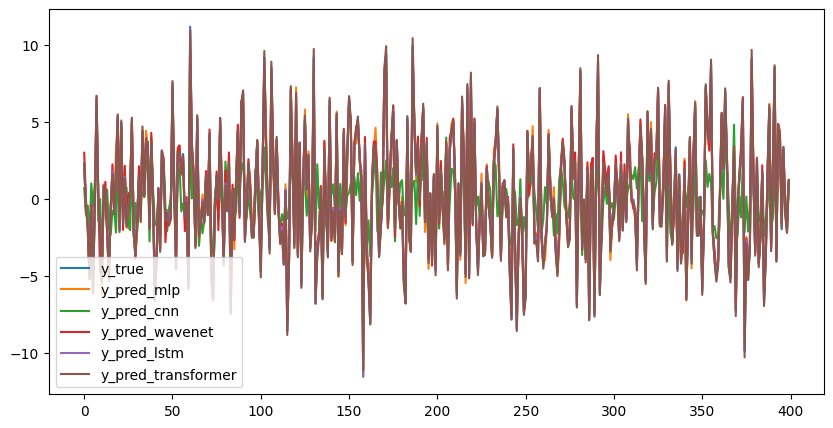

In [31]:
plt.figure(figsize=(10,5))
plt.plot(y_test, label='y_true')
plt.plot(y_pred_mlp.detach().numpy(), label='y_pred_mlp')
plt.plot(y_pred_cnn.detach().numpy(), label='y_pred_cnn')
plt.plot(y_pred_wavenet.detach().numpy(), label='y_pred_wavenet')
plt.plot(y_pred_lstm.detach().numpy(), label='y_pred_lstm')
plt.plot(y_pred_transformer.detach().numpy(), label='y_pred_transformer')
plt.legend()